In [14]:
import xgboost as xgb
from xgboost_distribution import XGBDistribution
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arrow
from sklearn.model_selection import train_test_split
import warnings
from  tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
events_calendar = pd.read_pickle('./data/events_calendar.pickle')
product_data = pd.read_pickle('./data/product_data.pickle')
product_history = pd.read_pickle('./data/product_history.pickle')

After taking an exploratory look at the data and what can help drive prediction, we have a clearer understanding of what might drive sales.

First, we assume that both the # of impressions and the price of all products are available as input throughout our prediction period. This is not such a stretch, because we would have both of these dictated by some stationary process - meaning a process that keeps the product competitive enough to generate steady sales. This assumption also helps us since we don't need to worry about competition this way, and we assume that increases in sales will follow from the auto-regressive changes in price. For example, if price goes down one day, we expect sales to go up - like during an event.

Secondaly, we noted that it will probably be possible to get a good predictions if we split sales of each product as a combination of temporary 'jumps' that happen when the product is first introduced, and the auto-regressive sales co-dependent on the # of impression. This was seen by examples toward the end of [eda.ipynb](./eda.ipynb). So our prediciton is simply given by:

$$ S(t) = J[\theta]\cdot \exp^{(\tau-t)\cdot \gamma[\theta]} + A(I_t, p_t, A_{t-1}) $$

Where $I_t$ are current/past impressions, $p_t$ are current/past prices, $A(I_t, p_t, A_{t-1})$ is the current and $A_{t-1}$ the previous auto-regressive component of sales, $\theta$ are product features, $J[\theta]$ is the magnitude and $\gamma[\theta]$ the decay dependent on the product features, and $\tau$ is when the product was released.

Note that $I_t$, $p_t$ and $A_{t-1}$ are past inputs on a window, while $A(\cdot | t)$ is stochastic with $A(\cdot | t) \rightarrow 0$ as $t \rightarrow 0$.

But we'll do something simpler - at least to code/implement. Before we model things out further, let's see how far we can get using XGBoost to have $J[\theta]$, $\gamma[\theta]$, and $A(\cdot | t)$ automatically modelled where we simply try to predict $S(t)$ given the product features $\theta$ and input windows $I_t$, $p_t$, $A_{t-1}$, and $\tau-t$, where $t$ is a cumulative period that can be measure by any period of time - 1 day, 3 days, 1 week, etc. So if we measure $t$ in steps of a week, then all other measures are aggregations over the 1 week.

In [5]:
next(iter(product_data.iterrows()))[1]

fsn                                                   DMKCGQS
when_added_ts                                      1569165217
name                 Apple iPhone 11 Pro Max Space Grey 64 GB
brand                                                   Apple
date_added                                2019-09-22 00:00:00
memory                                                    NaN
storage                                                  64.0
colors                                                 [gray]
premium_cat                                          1.463006
release_avg_price                               116943.116593
Name: 0, dtype: object

In [41]:
len(product_data.brand.unique())

34

In [83]:
periodWindow = 7
periodLags = 4
testSize = 0.2
lastDate = pd.Timestamp('2024-01-12 00:00:00')

trainX = np.ndarray([0, 7+3*periodLags])
testX = np.ndarray([0, 7+3*periodLags])
trainY = np.ndarray([0])
testY = np.ndarray([0])
trainT = np.ndarray([0])
testT = np.ndarray([0])

# The below generates the train/test sets by:
# 1. clipping the time-series
# 2. producing lag features of the time-series
# 3. appending product features
# 4. splitting into train/test X/Y/T
for idx, product in tqdm(product_data.iterrows()):
    df = product_history[
        (product_history.fsn == product.fsn) & \
        (pd.to_datetime(product_history.data_date) <= lastDate)
    ][[
        'data_date',
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'alpha_gross_gmv',
    ]].sort_values('data_date')
    df.index = pd.to_datetime(df.data_date)

    mask = (df.alpha_impressions > 0) | (df.alpha_primary_ppvs > 0) | (df.alpha_gross_units > 0)
    if sum(mask) <= 3:
        continue  # skip near-empty products, including new ones that don't have enough data to train, yet
    min_date = df[mask].data_date.min()
    max_date = df[mask].data_date.max()
    df = df[mask]

    dr = pd.date_range(start=min_date, end=max_date, freq='D')
    df = df.reindex(dr)
    df.loc[:, 'data_date'] = dr
    df.fillna(0, inplace=True)

    df['age'] = np.maximum(np.floor((pd.to_datetime(df.data_date) - product.date_added).dt.days / periodWindow), 0)
    df = df.groupby('age')[[
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'alpha_gross_gmv'
    ]].sum()
    if len(df) <= periodLags/(1-testSize):
        continue  # skip near-empty products, including new ones that don't have enough data to train, yet

    newdf = pd.DataFrame(index=df.index)
    newdf.loc[:,'pred_units'] = df['alpha_gross_units']
    newdf.loc[:,'ads'] = df['alpha_impressions']
    newdf.loc[:,'price'] = (df['alpha_gross_gmv'] / df['alpha_gross_units']).ffill().bfill()
    newdf.loc[:,'age'] = df.index
    newdf.loc[:,'brand'] = product.brand  # one-hot encoding in the very end
    newdf.loc[:,'memory'] = 0 if np.isnan(product.memory) else product.memory  # b/c no phone has 0 memory, it's a good choice for trees
    newdf.loc[:,'storage'] = 0 if np.isnan(product.storage) else product.storage  # b/c no phone has 0 storage, it's a good choice for trees
    # newdf.loc[:,'memory'] = product.memory
    # newdf.loc[:,'storage'] = product.storage
    newdf.loc[:,'premium_cat'] = product.premium_cat
    for j in range(1, periodLags+1):
        newdf.loc[:,f'units{j}'] = newdf.pred_units.shift(j).fillna(0)
        newdf.loc[:,f'ads{j}'] = newdf.ads.shift(j).fillna(0)
        newdf.loc[:,f'price{j}'] = newdf.price.shift(j).bfill()
        # newdf.loc[:,f'ads{j}'] = newdf.ads.shift(j)
        # newdf.loc[:,f'price{j}'] = newdf.price.shift(j)
        # newdf.loc[:,f'units{j}'] = newdf.pred_units.shift(j)

    trainX_, testX_, \
    trainY_, testY_, \
    trainT_, testT_ = train_test_split(newdf.values[:,1:], newdf.values[:,0], newdf.index.values, test_size=testSize)

    trainX = np.concatenate([trainX, trainX_], 0)
    testX = np.concatenate([testX, testX_], 0)
    trainY = np.concatenate([trainY, trainY_], 0)
    testY = np.concatenate([testY, testY_], 0)
    trainT = np.concatenate([trainT, trainT_], 0)
    testT = np.concatenate([testT, testT_], 0)
    
print(trainX.shape, testX.shape, \
    trainY.shape, testY.shape, \
    trainT.shape, testT.shape)

2923it [17:41,  2.75it/s]

(172976, 19) (45131, 19) (172976,) (45131,) (172976,) (45131,)


In [85]:
trainX = np.concatenate([trainX[:,np.arange(7+3*periodLags)!=3], pd.get_dummies(trainX[:,3]).values], 1).astype(float)
testX = np.concatenate([testX[:,np.arange(7+3*periodLags)!=3], pd.get_dummies(testX[:,3]).values], 1).astype(float)
trainY = trainY.astype(int)
testY = testY.astype(int)
trainT = trainT.astype(int)
testT = testT.astype(int)

print(trainX.shape, testX.shape, \
    trainY.shape, testY.shape, \
    trainT.shape, testT.shape)

(172976, 52) (45131, 52) (172976,) (45131,) (172976,) (45131,)


[0]	validation_0-Poisson-NLL:816.35169
[1]	validation_0-Poisson-NLL:794.56202
[2]	validation_0-Poisson-NLL:775.98573
[3]	validation_0-Poisson-NLL:759.13852
[4]	validation_0-Poisson-NLL:744.40000
[5]	validation_0-Poisson-NLL:730.51069
[6]	validation_0-Poisson-NLL:717.81485
[7]	validation_0-Poisson-NLL:705.49473
[8]	validation_0-Poisson-NLL:694.39975
[9]	validation_0-Poisson-NLL:683.54214
[10]	validation_0-Poisson-NLL:673.99026
[11]	validation_0-Poisson-NLL:664.86001
[12]	validation_0-Poisson-NLL:655.84519
[13]	validation_0-Poisson-NLL:647.27658
[14]	validation_0-Poisson-NLL:639.18488
[15]	validation_0-Poisson-NLL:631.08514
[16]	validation_0-Poisson-NLL:623.31874
[17]	validation_0-Poisson-NLL:615.77902
[18]	validation_0-Poisson-NLL:608.46559
[19]	validation_0-Poisson-NLL:601.38021
[20]	validation_0-Poisson-NLL:594.61199
[21]	validation_0-Poisson-NLL:588.04865
[22]	validation_0-Poisson-NLL:581.68327
[23]	validation_0-Poisson-NLL:575.58129
[24]	validation_0-Poisson-NLL:569.63400
[25]	valid

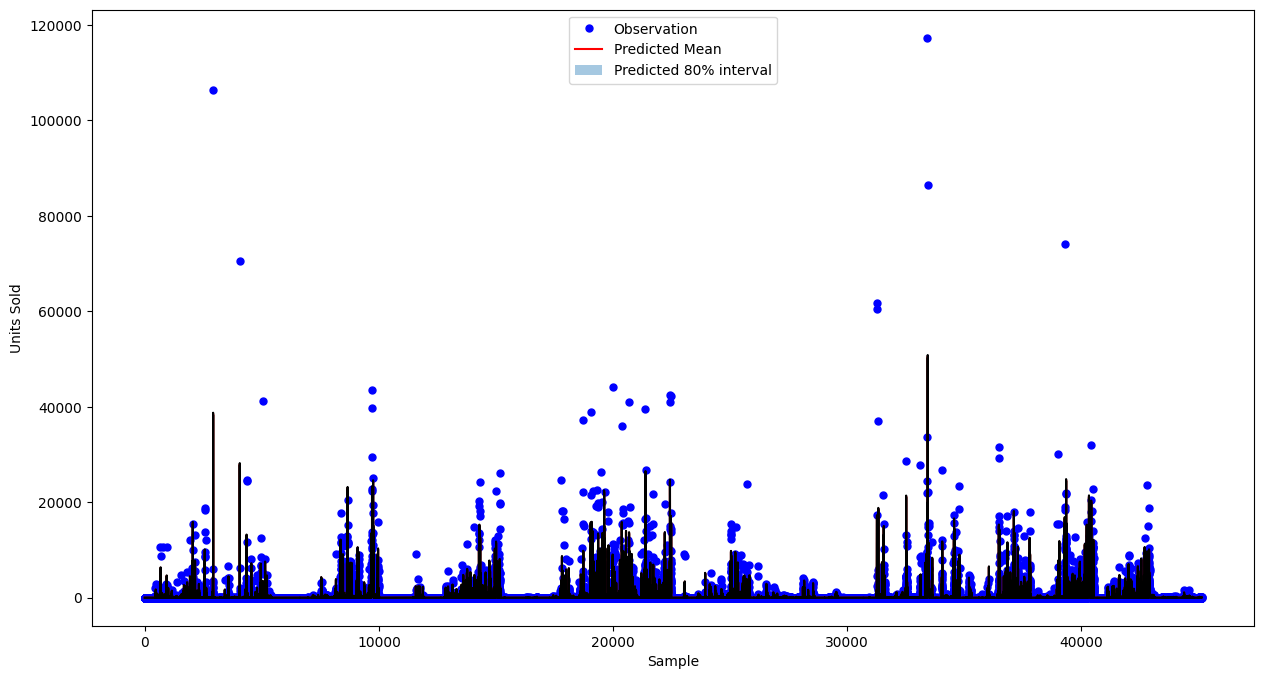

In [197]:

model = XGBDistribution(
    distribution="poisson",
    device="cuda",
    n_estimators=5000,
    max_depth=15,
    # subsample=0.8,
    # colsample_bytree=0.8,
    learning_rate=0.005,
    early_stopping_rounds=50,
)

model.fit(
    trainX,
    trainY,
    eval_set=[(testX, testY)],
    # verbose_eval=False,
)

testYpred = model.predict(testX)
low = stats.poisson.ppf(0.10, testYpred).T
med = stats.poisson.ppf(0.50, testYpred).T
high = stats.poisson.ppf(0.90, testYpred).T

# XY = xgb.QuantileDMatrix(trainX, trainY)
# testXY = xgb.QuantileDMatrix(testX, testY, ref=XY)
# # XY = xgb.DMatrix(trainX, trainY)
# # testXY = xgb.DMatrix(testX, testY)

# evals_result = dict()
# bstr = xgb.train(
#     {
#         "objective": "reg:quantileerror",
#         # "objective": "reg:squarederror",
#         "tree_method": "hist",
#         "device": "cuda",
#         "quantile_alpha": [0.1, 0.5, 0.9],
#         # "alpha": 0.1,
#         # "lambda": 0.1,
#         "learning_rate": 0.005,
#         "max_depth": 8,
#     },
#     XY,
#     num_boost_round=5000,
#     early_stopping_rounds=50,
#     evals=[(XY, 'Train'), (testXY, 'Test')],
#     evals_result=evals_result,
#     # verbose_eval=False,
# )

# testYpred = bstr.inplace_predict(testX)
# # med = testYpred
# low = testYpred[:,0]
# med = testYpred[:,1]
# high = testYpred[:,2]

plt.figure(figsize=(15, 8))
plt.plot(testY, "b.", markersize=10, label="Observation")
plt.plot(med, "r-", label="Predicted Mean")
plt.plot(high, "k-")
plt.plot(low, "k-")
plt.fill_between(
    np.arange(len(low)), np.ravel(low), np.ravel(high), alpha=0.4, label=f"Predicted {80}% interval"
)
plt.xlabel(f"Sample")
plt.ylabel(f"Units Sold")
plt.legend(loc="upper left")
plt.legend(loc='upper center')
plt.show()

In [198]:
((testY >= np.ravel(low)) & (testY <= np.ravel(high))).sum()/testY.shape[0]
# _ = plt.hist(np.abs(testY - np.ravel(med))/(testY + 1), bins=100)

0.6998515432851034

In [199]:
(np.abs(testY - np.ravel(med))/(testY + 1) > 0.10).sum()/len(testY) #(np.abs(testY - np.ravel(med))/(testY + 1) > 0.).sum()

0.43455717799295385

In [255]:
(np.abs(testY - np.ravel(med)).mean()/testY.mean())

0.462830222914112

Based on the validation set, 70% of the data is within the expected 80% bounds.

This is a really good validation fit!

If we look at the absolute percent error, about 57% of the sample points are within 10% of a absolute percent error.

The wMAPE of the validation sample is 46%. It's possible to improve this further if we only tried to fit the median, instead of 3 point marks. I will leave testing this out of the exercise.

Let's look at how this model evaluates on the Jan23 data, which was exclude in developing the model.

In [215]:
periodWindow = 7
periodLags = 4
testSize = 0.2
lastDate = pd.Timestamp('2024-01-19 00:00:00')
firstDate = pd.Timestamp('2023-12-12 00:00:00')

janX = np.ndarray([0, 7+3*periodLags])
janY = np.ndarray([0])
janT = np.ndarray([0])
fsnMap = dict()

for idx, product in tqdm(product_data.iterrows()):
    df = product_history[
        (product_history.fsn == product.fsn) & \
        (pd.to_datetime(product_history.data_date) <= lastDate) & \
        (pd.to_datetime(product_history.data_date) >= firstDate)
    ][[
        'data_date',
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'alpha_gross_gmv',
    ]].sort_values('data_date')
    df.index = pd.to_datetime(df.data_date)

    mask = (df.alpha_impressions > 0) | (df.alpha_primary_ppvs > 0) | (df.alpha_gross_units > 0)
    if sum(mask) <= 3:
        continue  # skip near-empty products, including new ones that don't have enough data to train, yet
    min_date = df[mask].data_date.min()
    max_date = df[mask].data_date.max()
    df = df[mask]

    dr = pd.date_range(start=min_date, end=max_date, freq='D')
    df = df.reindex(dr)
    df.loc[:, 'data_date'] = dr
    df.fillna(0, inplace=True)

    df['age'] = np.maximum(np.floor((pd.to_datetime(df.data_date) - product.date_added).dt.days / periodWindow), 0)
    dateMarks = df.groupby('age')[['data_date']].min()
    df = df.groupby('age')[[
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'alpha_gross_gmv'
    ]].sum()
    if len(df) == 0:
        continue  # skip near-empty products, including new ones that don't have enough data to train, yet

    newdf = pd.DataFrame(index=df.index)
    newdf.loc[:,'pred_units'] = df['alpha_gross_units']
    newdf.loc[:,'ads'] = df['alpha_impressions']
    newdf.loc[:,'price'] = (df['alpha_gross_gmv'] / df['alpha_gross_units']).ffill().bfill().fillna(0)
    newdf.loc[:,'age'] = df.index
    newdf.loc[:,'brand'] = product.brand  # one-hot encoding in the very end
    newdf.loc[:,'memory'] = 0 if np.isnan(product.memory) else product.memory  # b/c no phone has 0 memory, it's a good choice for trees
    newdf.loc[:,'storage'] = 0 if np.isnan(product.storage) else product.storage  # b/c no phone has 0 storage, it's a good choice for trees
    # newdf.loc[:,'memory'] = product.memory
    # newdf.loc[:,'storage'] = product.storage
    newdf.loc[:,'premium_cat'] = product.premium_cat
    for j in range(1, periodLags+1):
        newdf.loc[:,f'units{j}'] = newdf.pred_units.shift(j).fillna(0)
        newdf.loc[:,f'ads{j}'] = newdf.ads.shift(j).fillna(0)
        newdf.loc[:,f'price{j}'] = newdf.price.shift(len(df)-1).bfill() if len(df) < j else newdf.price.shift(j).bfill()
        # newdf.loc[:,f'ads{j}'] = newdf.ads.shift(j)
        # newdf.loc[:,f'price{j}'] = newdf.price.shift(j)
        # newdf.loc[:,f'units{j}'] = newdf.pred_units.shift(j)


    mask = (dateMarks.data_date <= pd.Timestamp('2024-01-19 00:00:00')) & \
    (dateMarks.data_date >= pd.Timestamp('2024-01-07 00:00:00'))

    janX_, janY_, janT_ = newdf[mask].values[:,1:], newdf[mask].values[:,0], ((pd.to_datetime(dateMarks[mask].data_date) - pd.Timestamp('2024-01-07 00:00:00')).dt.days % periodWindow)

    if len(janT_) == 1:
        janT_ = (janT_ + 1)/periodWindow
    elif len(janT_) == 2:
        janT_ = np.array([
            (janT_.values[0] + 1)/periodWindow,
            (periodWindow - janT_.values[1] - 1)/periodWindow
        ])
    else:
        continue  # skip products that don't have any data

    fsnMap[product.fsn] = len(janT_)
    janX = np.concatenate([janX, janX_], 0)
    janY = np.concatenate([janY, janY_], 0)
    janT = np.concatenate([janT, janT_], 0)
    
print(janX.shape, janY.shape, janT.shape)

2923it [26:37,  1.83it/s]

(3985, 19) (3985,) (3985,)


In [218]:
janX = np.concatenate([janX[:,np.arange(7+3*periodLags)!=3], pd.get_dummies(janX[:,3]).values], 1).astype(float)
janY = janY.astype(int)
janT = janT.astype(float)

print(janX.shape, janY.shape, janT.shape)

(3985, 52) (3985,) (3985,)


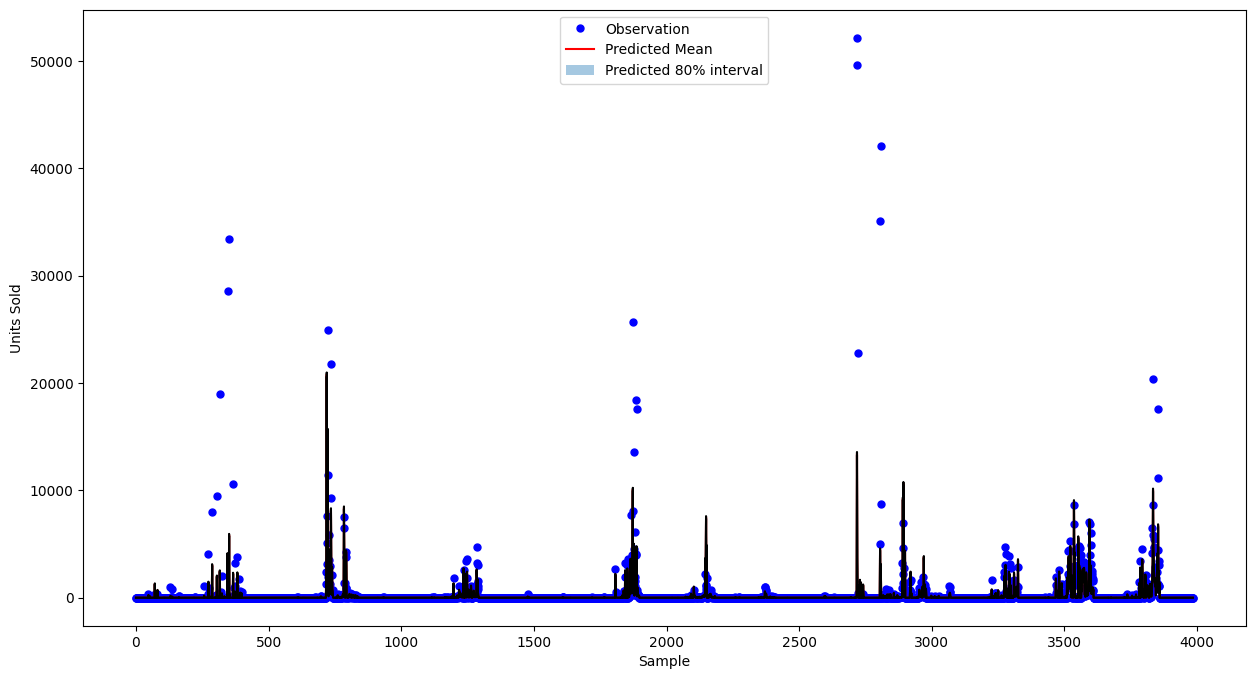

In [223]:
janYpred = model.predict(janX)
low = stats.poisson.ppf(0.10, janYpred).T
med = stats.poisson.ppf(0.50, janYpred).T
high = stats.poisson.ppf(0.90, janYpred).T

plt.figure(figsize=(15, 8))
plt.plot(janY, "b.", markersize=10, label="Observation")
plt.plot(med, "r-", label="Predicted Mean")
plt.plot(high, "k-")
plt.plot(low, "k-")
plt.fill_between(
    np.arange(len(low)), np.ravel(low), np.ravel(high), alpha=0.4, label=f"Predicted {80}% interval"
)
plt.xlabel(f"Sample")
plt.ylabel(f"Units Sold")
plt.legend(loc="upper left")
plt.legend(loc='upper center')
plt.show()

In [224]:
((janY >= np.ravel(low)) & (janY <= np.ravel(high))).sum()/janY.shape[0]

0.7646173149309912

In [225]:
(np.abs(janY - np.ravel(med))/(janY + 1) > 0.10).sum()/len(janY)

0.3480552070263488

In [251]:
(np.abs(janY - np.ravel(med)).mean()/(janY).mean())

0.5791482907557399

And now we see that the evaluation metrics are even better than the validation set used to train the model:
* 76% of the samples are within the 80% bounds.
* 65% of the samples are within less than 10% absolute percent error.
* the wMAPE is 58%

However, we note that the amount of zeros in the sample with greatly influence this statistic.

But we have one final step of merging samples that overlap the Jan24 event.

In [233]:
janT.shape

(3985,)

In [236]:
i = 0
result = dict()
for fsn, sz in fsnMap.items():
    result[fsn] = round((med[i:i+sz, 0] * janT[i:i+sz]).sum())
    i += sz

In [245]:
result = pd.DataFrame({"units": list(result.values())}, index=list(result.keys())).sort_values('units')

In [239]:
lastDate = pd.Timestamp('2024-01-19 00:00:00')
firstDate = pd.Timestamp('2024-01-13 00:00:00')

actual = product_history[
    (pd.to_datetime(product_history.data_date) <= lastDate) & \
    (pd.to_datetime(product_history.data_date) >= firstDate)
].groupby('fsn')[['alpha_gross_units']].sum()

In [248]:
final = actual.join(result, how='outer').fillna(0)

In [261]:
final['abs_pct_err'] = np.abs(final.units - final.alpha_gross_units) / (final.alpha_gross_units + 1)
final['abs_err'] = np.abs(final.units - final.alpha_gross_units)
final.sort_values('abs_err', ascending=False).head(50)

,alpha_gross_units,units,abs_pct_err,abs_err
4KJTPEN,52166.0,3690.0,0.929246,48476.0
QZ2QVFS,50730.0,2995.0,0.940943,47735.0
P3XETBR,39997.0,3710.0,0.907220,36287.0
PFYJSFT,49608.0,13427.0,0.729323,36181.0
B3VS24W,33394.0,5848.0,0.824854,27546.0
QNVFZZY,28563.0,4073.0,0.857373,24490.0
RYSFC5P,22806.0,1152.0,0.949445,21654.0
HBKKFSN,28360.0,6725.0,0.762843,21635.0
NDXSGHS,31937.0,11899.0,0.627403,20038.0
DQBD2B4,29026.0,9506.0,0.672477,19520.0


In [262]:
final.abs_err.mean()/final.alpha_gross_units.mean()

0.6561895967990151

The wMAPE on the actual event is 65%, slightly worse.
We compare this to our ability to get the total sales almost spot on, at ~4% absolute error, with far less sophisticated techniques.

Final Notes:
* the model heavily realies on embedding the product space in a tree model.
* we almost entirely relied on the price as input to estimate sales, rather than understand how competition between multiple products might affect the sales numbers. As mentioned earlier, because we don't set the price here, then this is the best option.
* the product_data table is extremely noisy and feature poor. While I cleaned and added as many features as possible, this has its limits. Cleaner, tabulated product features would go a long way to design better embeddings.

Ah, and P.S. Below are predictions for products released during the Jan 2024 event.

In [268]:
final[
    final.index.isin(product_data[
        (pd.to_datetime(product_data.date_added) <= lastDate) & \
        (pd.to_datetime(product_data.date_added) >= firstDate)
    ].fsn)
]

,alpha_gross_units,units,abs_pct_err,abs_err
2H9CY7Y,3465.0,1171.0,0.661858,2294.0
2VUZ2F8,1050.0,327.0,0.687916,723.0
4PA7H5Z,4472.0,2911.0,0.348983,1561.0
4TJHXW2,1588.0,579.0,0.634991,1009.0
7F5KBV2,1916.0,374.0,0.804382,1542.0
9GUTVDT,2473.0,769.0,0.688763,1704.0
AYAEN5R,605.0,753.0,0.244224,148.0
DHDKN4X,1732.0,549.0,0.682631,1183.0
DZHMSEY,515.0,461.0,0.104651,54.0
HBHMSPR,2199.0,516.0,0.765000,1683.0
